# Different Behaviour of the Gas-Phase and Stellar Metallicity in The Central Part of Manga Galaxies

This notebook aims to replicate the results obtained by [Zinchenko et al. (2024)](https://arxiv.org/pdf/2407.21160).

In [2]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
import yaml

In [1]:
from auriga.parser import parse
from auriga.images import figure_setup
from auriga.snapshot import Snapshot
from auriga.settings import Settings
from auriga.physics import Physics

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/setuptools/_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.


In [4]:
CONFIG_FILE: str = "02"

In [38]:
figure_setup()
settings = Settings()
config = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))
sample = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]

In [8]:
def read_data(simulation: str, abundances: list) -> tuple:
    """
    This method returns data of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.
    abundances : tuple
        A list of tuples with the abundances to calculate.

    Returns
    -------
    pd.DataFrame
        A data frame with the properties.
    """

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_extra_coordinates()

    for of, to in abundances:
        s.add_metal_abundance(of, to)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_gas = (s.type == 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    return_mask = (is_real_star | is_gas) & is_main_obj

    data = {
        "CylindricalRadius_ckpc": s.rho[return_mask],
        "SphericalRadius_ckpc": s.r[return_mask],
        "ParticleType": s.type[return_mask],
    }

    for of, to in abundances:
        data[f"[{of}/{to}]"] = s.metal_abundance[f"{of}/{to}"][return_mask]
        data[f"[{of}/{to}]"][~np.isfinite(data[f"[{of}/{to}]"])] = np.nan

    data = pd.DataFrame(data)

    for of, to in abundances:
        data = data[data[f"[{of}/{to}]"].notna()]

    return data

In [69]:
stellar_masses = []
delta_abundances = [[], [], [], []]
for simulation in sample:
    # Galaxy stellar mass
    gal_data = pd.read_csv("../data/iza_2022.csv")
    galaxy, rerun, resolution, _ = parse(simulation)
    is_galaxy = (gal_data["Galaxy"] == galaxy) & (gal_data["Rerun"] == int(rerun)) & (gal_data["Resolution"] == resolution)
    stellar_mass = gal_data["SubhaloStellarMass_10^10Msun"][is_galaxy].iloc[0]
    stellar_masses.append(stellar_mass)

    df = read_data(simulation, [("Fe", "H"), ("Mg", "Fe"), ("O", "Fe")])

    for i, distance in enumerate([10.0, 20.0, 30.0, 40.0]):
        is_gas = df["ParticleType"] == 0
        is_star = df["ParticleType"] == 4
        is_inner = df["SphericalRadius_ckpc"] <= distance
        delta_abundance = np.mean(df["[Fe/H]"][is_gas & is_inner]) - np.mean(df["[Fe/H]"][is_star & is_inner])
        delta_abundances[i].append(delta_abundance)

df = pd.DataFrame({"SubhaloStellarMass_10^10Msun": stellar_masses,
                   "Delta[Fe/H]_10ckpc": delta_abundances[0],
                   "Delta[Fe/H]_20ckpc": delta_abundances[1],
                   "Delta[Fe/H]_30ckpc": delta_abundances[2],
                   "Delta[Fe/H]_40ckpc": delta_abundances[3]})

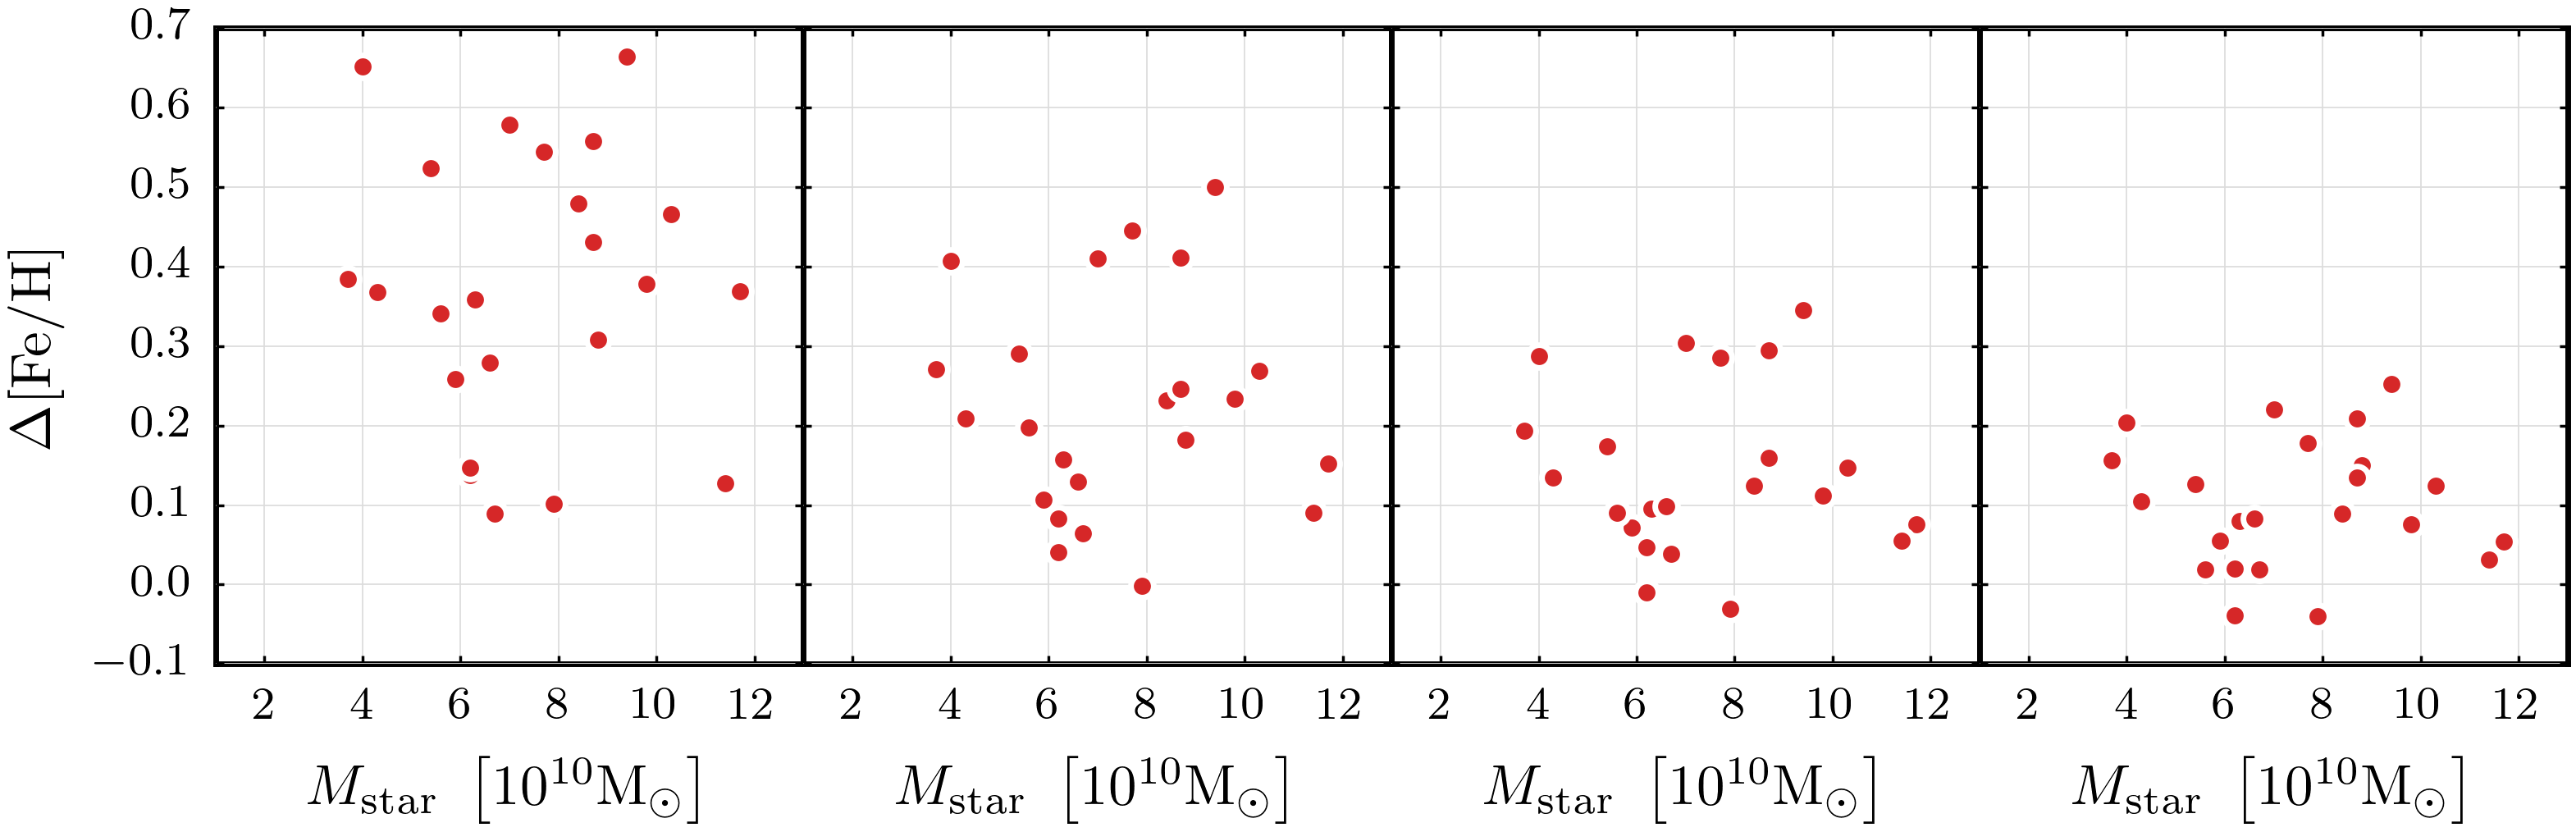

In [74]:
fig = plt.figure(figsize=(7.4, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flat:
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(1, 13)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xlabel(r"$M_\mathrm{star} ~ \left[ 10^{10} \mathrm{M}_\odot \right]$")
    # ax.set_ylim(-0.6, -0.1)
    ax.set_ylabel(r"$\Delta$[Fe/H]")
    ax.grid(True, ls='-', lw=0.25, c="gainsboro")
    ax.label_outer()

axs[0].scatter(df["SubhaloStellarMass_10^10Msun"], df["Delta[Fe/H]_10ckpc"],
               s=16, edgecolor="white", facecolor="tab:red",
               color="tab:red", zorder=15)
axs[1].scatter(df["SubhaloStellarMass_10^10Msun"], df["Delta[Fe/H]_20ckpc"],
               s=16, edgecolor="white", facecolor="tab:red",
               color="tab:red", zorder=15)
axs[2].scatter(df["SubhaloStellarMass_10^10Msun"], df["Delta[Fe/H]_30ckpc"],
               s=16, edgecolor="white", facecolor="tab:red",
               color="tab:red", zorder=15)
axs[3].scatter(df["SubhaloStellarMass_10^10Msun"], df["Delta[Fe/H]_40ckpc"],
               s=16, edgecolor="white", facecolor="tab:red",
               color="tab:red", zorder=15)

plt.show()